In [4]:
import statsapi
import pandas as pd


## Preprocessing

In [5]:
players = pd.read_csv("mlb_players_2021.csv")
pitches = pd.read_csv("regseason.csv")

In [6]:
players.rename(columns={"id" : "batter","fullName" : "batter_fullName" , "birthCountry" : "batter_birthCountry"}, inplace=True)
players.head()

,batter,batter_fullName,birthDate,batter_birthCountry,height,weight,primaryPosition,batSide,pitchHand,debutDate,active
0,642758,Domingo Acevedo,1994-03-06,Dominican Republic,"6' 7""",240,P,R,R,2021-06-21,True
1,664119,Austin Allen,1994-01-16,USA,"6' 1""",219,C,L,R,2019-05-11,False
2,462101,Elvis Andrus,1988-08-26,Venezuela,"6' 0""",210,SS,R,R,2009-04-06,False
3,642456,Luis Barrera,1995-11-15,Dominican Republic,"6' 0""",195,OF,L,L,2021-05-19,True
4,605135,Chris Bassitt,1989-02-22,USA,"6' 5""",217,P,R,R,2014-08-30,True


In [7]:
# Merge pitches df with info about the batter
full_df = pd.merge(pitches, players[["batter","batter_fullName","batSide", "batter_birthCountry"]], on="batter")
full_df.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,count,PBhand,pitch_cat,batter_fullName,batSide,batter_birthCountry
0,1,SL,2021-10-03,85.1,2.39,6.05,"Detmers, Reid",641487,672282,single,...,Standard,293.0,0.079,0.780,0_1,bLpL,breaking,J.P. Crawford,L,USA
1,2,FF,2021-10-03,93.8,2.31,6.03,"Detmers, Reid",641487,672282,NaN,...,Standard,150.0,0.000,-0.045,0_0,bLpL,fastball,J.P. Crawford,L,USA
2,3,CU,2021-10-03,73.9,2.12,6.25,"Detmers, Reid",664238,672282,strikeout,...,Standard,329.0,-0.032,-0.315,2_2,bRpL,breaking,Dylan Moore,R,USA
3,4,FF,2021-10-03,94.6,2.43,5.96,"Detmers, Reid",664238,672282,NaN,...,Standard,146.0,0.000,0.047,1_2,bRpL,fastball,Dylan Moore,R,USA
4,5,FF,2021-10-03,94.3,2.08,6.15,"Detmers, Reid",664238,672282,NaN,...,Standard,151.0,0.000,0.000,1_2,bRpL,fastball,Dylan Moore,R,USA


In [8]:
# Remove the pitches that were fouled, in play, or swung at
not_hit = ["called_strike", "ball"]
pitches_not_hit = full_df[full_df['description'].isin(not_hit)].copy()
len(pitches_not_hit)
pitches_not_hit.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,count,PBhand,pitch_cat,batter_fullName,batSide,batter_birthCountry
2,3,CU,2021-10-03,73.9,2.12,6.25,"Detmers, Reid",664238,672282,strikeout,...,Standard,329.0,-0.032,-0.315,2_2,bRpL,breaking,Dylan Moore,R,USA
3,4,FF,2021-10-03,94.6,2.43,5.96,"Detmers, Reid",664238,672282,NaN,...,Standard,146.0,0.000,0.047,1_2,bRpL,fastball,Dylan Moore,R,USA
6,7,FF,2021-10-03,94.2,2.33,5.94,"Detmers, Reid",664238,672282,NaN,...,Standard,145.0,0.000,0.032,0_1,bRpL,fastball,Dylan Moore,R,USA
9,10,CU,2021-10-03,73.9,2.22,6.23,"Detmers, Reid",663728,672282,NaN,...,Standard,322.0,0.000,0.174,2_2,bRpL,breaking,Cal Raleigh,S,USA
12,13,FF,2021-10-03,94.4,2.48,5.97,"Detmers, Reid",663728,672282,NaN,...,Standard,148.0,0.000,0.062,1_2,bRpL,fastball,Cal Raleigh,S,USA


In [29]:
pitches_not_hit["strike_zone"] = pitches_not_hit["zone"] <= 9 # Determine if the pitch was actually in the zone

pitches_not_hit["called_correctly"] = (
    ((pitches_not_hit["zone"] <= 9) & (pitches_not_hit["type"] == "S")) | # Pitch is in the zone and is called a strike  
    ((pitches_not_hit["zone"] > 9) & (pitches_not_hit["type"] == "B"))    # Pitch is not in the zone and is called a ball
) 
pitches_not_hit["called_correctly"] = pitches_not_hit["called_correctly"].astype(int) # This will be are target variable -- whether the pitch was called "correctly"

In [52]:
pitches_not_hit["babip_value"].unique()

array([ 0., nan])

In [60]:
pitches_not_hit["iso_value"].unique()

array([ 0., nan])

## New addition

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Creating a new variable to see if a game altering event (out or man on base) came as a result of the pitch
pitches_not_hit['has_event'] = pitches_not_hit['events'].notna().astype(int) 
y = pitches_not_hit["called_correctly"]
X= pitches_not_hit.drop(["called_correctly"], axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.head()

# Combining into a new df
train_df = X_train.copy()
train_df['target'] = y_train

# Split into correct/incorrect
majority = train_df[train_df['target'] == 1]  # Correct calls
minority = train_df[train_df['target'] == 0]  # Incorrect calls

# Downsample majority
majority_downsampled = resample(
    majority,
    replace=False,# No replacement
    n_samples=len(minority),# Match number of minority examples
    random_state=42
)

#Combine back
train_balanced = pd.concat([majority_downsampled, minority])
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Set up x and y train balanced
X_train_balanced = train_balanced.drop(columns=['target'])
y_train_balanced = train_balanced['target']

In this code chunk, I set up X and y train, but balance the datasets so there are an equal number of correct and incorrectly called pitches so the model doesn't just predict pitches called correctly

### Running loop with all features

In [61]:
all_quant_cols = [  # only numerical features
    'release_speed', 'release_pos_x', 'release_pos_z', 'zone', 'balls', 'strikes',
    'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'outs_when_up', 'inning',
    'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate', 'release_extension',
    'release_pos_y', 'at_bat_number', 'pitch_number', 'home_score', 'away_score', 'bat_score',
    'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score',
    'post_fld_score', 'spin_axis', 'delta_home_win_exp', 'has_event'
]

all_qual_cols = [
    'pitch_type', 'game_date', 'player_name', 'events', 'description', 'des', 'game_type',
 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'inning_topbot', 'pitch_name',
 'if_fielding_alignment', 'of_fielding_alignment', 'count', 'PBhand', 'pitch_cat', 
 'batter_fullName', 'batSide', 'batter_birthCountry', 'strike_zone'
]


In [ ]:
# two quant, one qual
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

best_score = 0
best_cols = []

min_datapoints = 500
# Total number of combinations
total_combos = len(all_qual_cols) * len(list(combinations(all_quant_cols, 2)))

# Initialize progress bar
with tqdm(total=total_combos, desc="Evaluating combinations") as pbar:
    for qual in all_qual_cols:
        for pair in combinations(all_quant_cols, 2): 
            cols = list(pair) + [qual]  # use just the current qualitative column
            try:
                # Drop rows with NaNs in selected columns only
                X_sub = X_train_balanced[cols].dropna()
                y_sub = y_train_balanced.loc[X_sub.index]

                if len(X_sub) < min_datapoints:
                    continue

                LR = LogisticRegression()
                LR.fit(X_sub, y_sub)
                score = LR.score(X_sub, y_sub)

                if score > best_score:
                    best_score = score
                    best_cols = cols
                    print(f"\n✅ New best score: {best_score:.4f} with features: {best_cols}")
            except KeyError:
                pass
            except ValueError:
                pass
            finally:
                pbar.update(1)

Evaluating combinations:  70%|██████▉   | 8970/12903 [01:03<00:28, 140.09it/s]


✅ New best score: 0.5281 with features: ['release_speed', 'release_pos_x', 'count']

✅ New best score: 0.5306 with features: ['release_speed', 'zone', 'count']

✅ New best score: 0.5468 with features: ['release_speed', 'balls', 'count']

✅ New best score: 0.5474 with features: ['release_speed', 'strikes', 'count']


Evaluating combinations:  70%|██████▉   | 9011/12903 [01:05<02:43, 23.79it/s] 


✅ New best score: 0.5479 with features: ['release_pos_x', 'zone', 'count']


Evaluating combinations:  70%|███████   | 9093/12903 [01:09<02:59, 21.28it/s]


✅ New best score: 0.5512 with features: ['zone', 'pitch_number', 'count']


Evaluating combinations:  71%|███████   | 9105/12903 [01:10<02:51, 22.17it/s]


✅ New best score: 0.5542 with features: ['zone', 'has_event', 'count']


Evaluating combinations:  71%|███████   | 9134/12903 [01:11<02:48, 22.40it/s]


✅ New best score: 0.5582 with features: ['balls', 'has_event', 'count']


Evaluating combinations:  96%|█████████▌| 12383/12903 [01:54<00:16, 31.21it/s] 


✅ New best score: 0.5625 with features: ['release_speed', 'has_event', 'strike_zone']


Evaluating combinations:  96%|█████████▌| 12413/12903 [01:55<00:15, 30.74it/s]


✅ New best score: 0.5628 with features: ['release_pos_x', 'has_event', 'strike_zone']


Evaluating combinations:  97%|█████████▋| 12504/12903 [01:59<00:09, 40.00it/s]


✅ New best score: 0.5690 with features: ['strikes', 'plate_x', 'strike_zone']


Evaluating combinations:  97%|█████████▋| 12530/12903 [01:59<00:08, 42.72it/s]


✅ New best score: 0.5811 with features: ['strikes', 'has_event', 'strike_zone']


Evaluating combinations: 100%|██████████| 12903/12903 [02:12<00:00, 97.59it/s]


In [63]:
print(best_cols)
print(best_score)

['strikes', 'has_event', 'strike_zone']
0.5810566904586102


The best columns I find are pitch number, the total number of at pitches thrown in an at bat, delta_run_exp, the change in run expentency before and after the pitch, and strike zone, depicting if a pitch is called correctly or not.

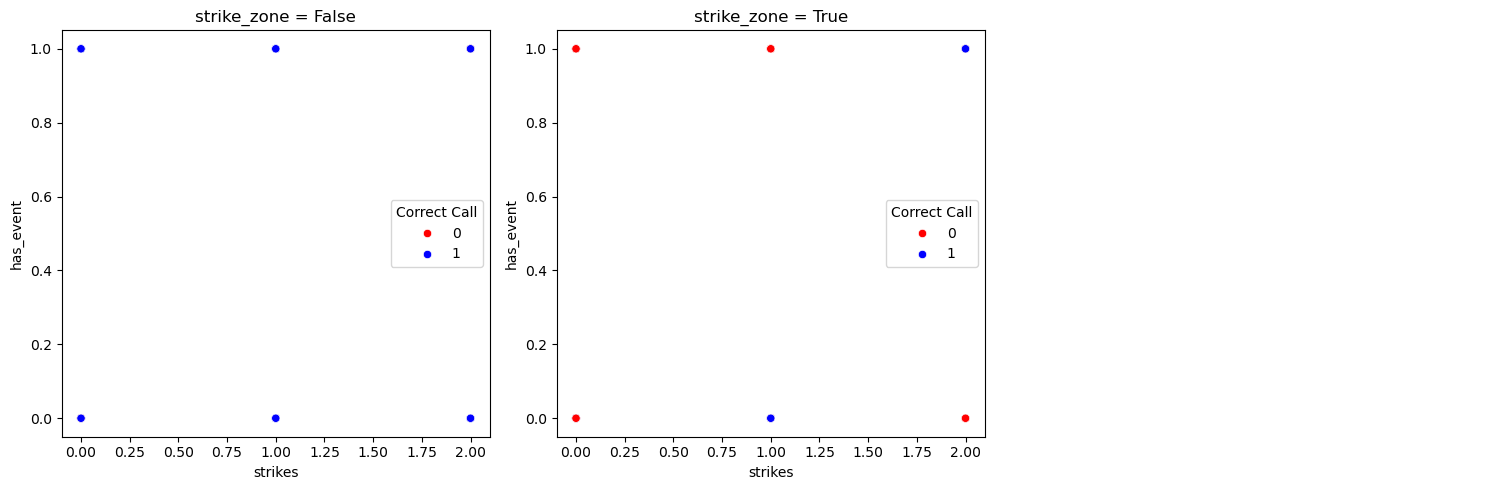

In [64]:
# visualizing model

import matplotlib.pyplot as plt
import seaborn as sns


quant1, quant2, qual = best_cols  # Unpack

# Set up the full dataframe
plot_df = X_train_balanced[[quant1, quant2, qual]].copy()
plot_df['target'] = y_train_balanced.values  # Add back the target

# Unique categories in the qualitative variable
categories = plot_df[qual].dropna().unique()

# Set up subplots
n_categories = len(categories)
n_cols = 3
n_rows = (n_categories + n_cols - 1) // n_cols  # rounds up
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5), squeeze=False)

# Plot each category
for idx, category in enumerate(categories):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]

    # Filter only this category
    cat_df = plot_df[plot_df[qual] == category]

    # Scatterplot
    sns.scatterplot(
        data=cat_df,
        x=quant1,
        y=quant2,
        hue='target',
        palette={0: 'red', 1: 'blue'},
        ax=ax
    )

    ax.set_title(f"{qual} = {category}")
    ax.legend(title="Correct Call", loc='best')

# Hide unused subplots
for idx in range(len(categories), n_rows*n_cols):
    row = idx // n_cols
    col = idx % n_cols
    axes[row][col].axis('off')

plt.tight_layout()
plt.show()


In [67]:
# two qual, one quant
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

best_score = 0
best_cols = []

min_datapoints = 500
# Total number of combinations
total_combos = len(all_qual_cols) * len(list(combinations(all_quant_cols, 2)))

# Initialize progress bar
with tqdm(total=total_combos, desc="Evaluating combinations") as pbar:
    for quant in all_quant_cols:
        for pair in combinations(all_qual_cols, 2): 
            cols = list(pair) + [quant]  # use just the current qualitative column
            try:
                # Drop rows with NaNs in selected columns only
                X_sub = X_train_balanced[cols].dropna()
                y_sub = y_train_balanced.loc[X_sub.index]

                if len(X_sub) < min_datapoints:
                    continue

                LR = LogisticRegression()
                LR.fit(X_sub, y_sub)
                score = LR.score(X_sub, y_sub)

                if score > best_score:
                    best_score = score
                    best_cols = cols
                    print(f"\n✅ New best score: {best_score:.4f} with features: {best_cols}")
            except KeyError:
                pass
            except ValueError:
                pass
            finally:
                pbar.update(1)

Evaluating combinations:   2%|▏         | 263/12903 [00:01<01:47, 117.37it/s]


✅ New best score: 0.5476 with features: ['count', 'strike_zone', 'release_speed']


Evaluating combinations:   4%|▍         | 513/12903 [00:03<01:22, 150.46it/s]


✅ New best score: 0.5479 with features: ['count', 'strike_zone', 'release_pos_x']


Evaluating combinations:   6%|▌         | 770/12903 [00:05<01:28, 136.99it/s]


✅ New best score: 0.5483 with features: ['count', 'strike_zone', 'release_pos_z']


Evaluating combinations:  45%|████▌     | 5827/12903 [00:36<00:42, 168.39it/s]


✅ New best score: 0.5507 with features: ['count', 'strike_zone', 'pitch_number']


Evaluating combinations:  67%|██████▋   | 8602/12903 [00:52<00:26, 162.36it/s]


✅ New best score: 0.5596 with features: ['count', 'strike_zone', 'has_event']


### Takeaways

Both models don't have great accuracy in predicting what makes an umpire call pitches correctly and inccorectly. While the accuracy is slightly better than 50%, it isn't much, so we need to play around with using other models, perhaps some deep learning to continue to test this. These results could also mean that umps are just good at their jobs, and their missed calls happen at random times.

### Running on Select Features

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,delta_home_win_exp,delta_run_exp,count,PBhand,pitch_cat,batter_fullName,batSide,batter_birthCountry,strike_zone,has_event
176719,158575,CU,2021-05-09,73.2,-1.24,6.49,"Wainwright, Adam",606132,425794,NaN,...,0.0,0.057,1_2,bLpR,breaking,Raimel Tapia,L,Dominican Republic,False,0
274509,245826,KC,2021-06-22,82.9,-1.72,5.63,"DeSclafani, Anthony",660271,543101,NaN,...,0.0,0.014,0_1,bLpR,breaking,Shohei Ohtani,L,Japan,False,0
312688,280329,FF,2021-09-23,96.7,-3.27,4.82,"Ramirez, Yohan",516782,670990,NaN,...,0.0,0.131,2_0,bRpR,fastball,Starling Marte,R,Dominican Republic,False,0
573370,513628,SI,2021-09-24,90.8,-0.32,5.58,"Gray, Sonny",657041,543243,NaN,...,0.0,-0.028,2_1,bRpR,fastball,Lane Thomas,R,USA,True,0
350886,314748,CH,2021-06-26,85.6,-3.67,5.87,"Floro, Dylan",665742,571670,NaN,...,0.0,0.038,0_0,bLpR,offspeed,Juan Soto,L,Dominican Republic,False,0


In [ ]:
all_quant_cols = [  # only numerical features
    'release_speed', 'release_pos_x', 'release_pos_z', 'zone', 'balls', 'strikes',
    'outs_when_up', 'inning',
    'at_bat_number', 'pitch_number', 'home_score', 'away_score', 'bat_score',
    'fld_score', 'delta_home_win_exp', 'delta_run_exp', 'has_event'
]

all_qual_cols = [
    'pitch_type', 'game_date', 'player_name', 'events', 'description', 'des', 'game_type',
 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'inning_topbot', 'pitch_name',
 'if_fielding_alignment', 'of_fielding_alignment', 'count', 'PBhand', 'pitch_cat', 
 'batter_fullName', 'batSide', 'batter_birthCountry', 'strike_zone'
]

In [21]:

from itertools import combinations
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

best_score = 0
best_cols = []

min_datapoints = 500
# Total number of combinations
total_combos = len(all_qual_cols) * len(list(combinations(all_quant_cols, 2)))

# Initialize progress bar
with tqdm(total=total_combos, desc="Evaluating combinations") as pbar:
    for qual in all_qual_cols:
        for pair in combinations(all_quant_cols, 2): 
            cols = list(pair) + [qual]  # use just the current qualitative column
            try:
                # Drop rows with NaNs in selected columns only
                X_sub = X_train[cols].dropna()
                y_sub = y_train.loc[X_sub.index]

                if len(X_sub) < min_datapoints:
                    continue

                LR = LogisticRegression()
                LR.fit(X_sub, y_sub)
                score = LR.score(X_sub, y_sub)

                if score > best_score:
                    best_score = score
                    best_cols = cols
                    print(f"\n✅ New best score: {best_score:.4f} with features: {best_cols}")
            except KeyError:
                pass
            except ValueError:
                pass
            finally:
                pbar.update(1)

Evaluating combinations:  70%|██████▉   | 2177/3128 [01:30<01:13, 12.86it/s]


✅ New best score: 0.9174 with features: ['release_speed', 'release_pos_x', 'count']


Evaluating combinations:  70%|███████   | 2193/3128 [01:36<04:59,  3.12it/s]


✅ New best score: 0.9174 with features: ['release_pos_x', 'release_pos_z', 'count']


Evaluating combinations: 100%|██████████| 3128/3128 [02:53<00:00, 18.03it/s]


In [22]:
print(best_cols)
print(best_score)

['release_pos_x', 'release_pos_z', 'count']
0.9173598949211909
